In [8]:
from typing import Any, Iterator, Mapping, Optional, Tuple, Sequence

from lfiax.flows.nsf import make_nsf

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


# ----------------------------------------
# Helper functions to load and process data
# ----------------------------------------
def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
  ds = tfds.load("mnist", split=split, shuffle_files=True)
  # ds = split
  ds = ds.shuffle(buffer_size=10 * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=1000)
  ds = ds.repeat()
  return iter(tfds.as_numpy(ds))


def one_hot_mnist(x, dtype=jnp.float32):
  """Create a one-hot encoding of x of size 10 for MNIST."""
  return jnp.array(x[:, None] == jnp.arange(10), dtype)


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
  data = batch["image"].astype(np.float32)
  label = batch["label"].astype(np.float32)
  label = one_hot_mnist(label)
  label = jnp.expand_dims(label, -1)
  if prng_key is not None:
    # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
    data += jax.random.uniform(prng_key, data.shape)
  return data / 256., label  # Normalize pixel values from [0, 256) to [0, 1).


# ----------------------------
# Haiku transform functions for training and evaluation
# ----------------------------
@hk.without_apply_rng
@hk.transform
def log_prob(data: Array, cond_data: Array) -> Array:
  model = make_nsf(
      event_shape=MNIST_IMAGE_SHAPE,
      cond_info_shape=cond_info_shape,
      num_layers=flow_num_layers,
      hidden_sizes=[hidden_size] * mlp_num_layers,
      num_bins=num_bins,
      standardize_x=False,
      base_dist='uniform',
      )
  return model.log_prob(data, cond_data)

@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int, cond_data: Array) -> Array:
  model = make_nsf(
      event_shape=MNIST_IMAGE_SHAPE,
      cond_info_shape=cond_info_shape,
      num_layers=flow_num_layers,
      hidden_sizes=[hidden_size] * mlp_num_layers,
      num_bins=num_bins,
      standardize_x=False,
      base_dist='uniform',
      )
  z = jnp.repeat(cond_data, num_samples, axis=0)
  z = jnp.expand_dims(z, -1)
  return model._sample_n(key=key, 
                         n=[num_samples],
                         z=z)

def loss_fn(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:
  data = prepare_data(batch, prng_key)
  # Loss is average negative log likelihood.
  loss = -jnp.mean(log_prob.apply(params, data[0], data[1]))
  return loss

@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
  data = prepare_data(batch)  # We don't dequantize during evaluation.
  loss = -jnp.mean(log_prob.apply(params, data[0], data[1]))
  return loss

@jax.jit
def update(params: hk.Params,
            prng_key: PRNGKey,
            opt_state: OptState,
            batch: Batch) -> Tuple[hk.Params, OptState]:
  """Single SGD update step."""
  grads = jax.grad(loss_fn)(params, prng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [5]:
MNIST_IMAGE_SHAPE = (28, 28, 1)
cond_info_shape = (10,1)
batch_size = 128

flow_num_layers = 10
mlp_num_layers = 4
hidden_size = 500
num_bins = 4
learning_rate = 1e-4

training_steps =  5000
eval_frequency =  100

optimizer = optax.adam(learning_rate)

# Training
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(next(prng_seq), 
                    np.zeros((1, *MNIST_IMAGE_SHAPE)), 
                    np.zeros((1, *cond_info_shape)))
opt_state = optimizer.init(params)

train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset(tfds.Split.TEST, batch_size)

for step in range(training_steps):
  params, opt_state = update(params, next(prng_seq), opt_state,
                              next(train_ds))

  if step % eval_frequency == 0:
    val_loss = eval_fn(params, next(valid_ds))
    print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
STEP:     0; Validation loss: -2.615
STEP:   100; Validation loss: -3107.718
STEP:   200; Validation loss: -3637.989
STEP:   300; Validation loss: -3503.495
STEP:   400; Validation loss: -3418.740
STEP:   500; Validation loss: -3375.061
STEP:   600; Validation loss: -3246.892
STEP:   700; Validation loss: -3199.542
STEP:   800; Validation loss: -3137.122
STEP:   900; Validation loss: -3112.863
STEP:  1000; Validation loss: -3073.159
STEP:  1100; Validation loss: -3003.211
STEP:  1200; Validation loss: -2947.844
STEP:  1300; Validation loss: -2932.786
STEP:  1400; Validation loss: -2900.614
STEP:  1500; Validation loss: -2812.903
STEP:  1600; Validation loss: -2754.821
STEP:  1700; Validation loss: -2694.783
STEP:  1800; Validation loss: -2776.074
STEP:  1900; Validation loss: -2710.726
STEP:  2000; Validation loss: -2653.653
STEP:  2100; Validation loss: -2633.241
STEP:  2

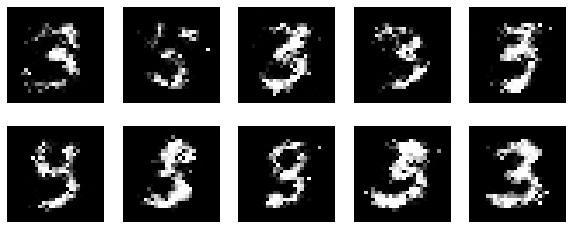

In [6]:
import matplotlib.pyplot as plt

samples = 10

def plot_batch(batch: Batch) -> None:
  """Plots a batch of conditional MNIST digits."""
  images = batch.reshape((-1,) + MNIST_IMAGE_SHAPE)
  plt.figure(figsize=(10, 4))
  for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.squeeze(images[i]), cmap="gray")
    plt.axis("off")
  plt.show()

sample = model_sample.apply(params, 
                            next(prng_seq), 
                            num_samples=samples, 
                            cond_data=one_hot_mnist(jnp.array([3])))

plot_batch(sample)

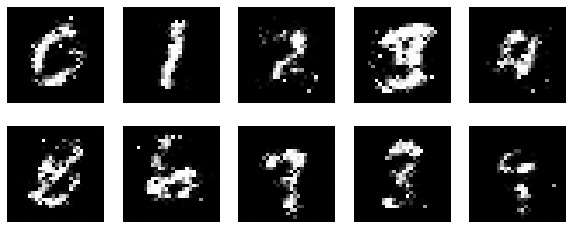

In [9]:
def plot_batch(batch: Sequence[Batch]) -> None:
  """Plots a batch of MNIST digits."""
  images = []
  for img in batch:
    images.append(img.reshape((-1,) + MNIST_IMAGE_SHAPE))
  # images = batch.reshape((-1,) + MNIST_IMAGE_SHAPE)
  plt.figure(figsize=(10, 4))
  for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.squeeze(images[i]), cmap="gray")
    plt.axis("off")
  plt.show()

samples = []
for i in range(10):
  samples.append(
      model_sample.apply(params, next(prng_seq), num_samples=1, 
                            cond_data=one_hot_mnist(jnp.array([i])))
  )

plot_batch(samples)